# 2S-piRCNN 1st stage

## 前置準備

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(0)
import matplotlib.pyplot as plt
from sklearn import metrics

Modify graph size

In [2]:
#plt.rcParams["figure.figsize"]=[6,4]
plt.rcParams["figure.figsize"] = (12,8)

Load data

In [3]:
#data_l1
train0_l1 = pd.read_pickle("./Datasets/train0_l1.pkl")
train1_l1 = pd.read_pickle("./Datasets/train1_l1.pkl")
train2_l1 = pd.read_pickle("./Datasets/train2_l1.pkl")
train3_l1 = pd.read_pickle("./Datasets/train3_l1.pkl")
train4_l1 = pd.read_pickle("./Datasets/train4_l1.pkl")
cv0_l1 = pd.read_pickle("./Datasets/cv0_l1.pkl")
cv1_l1 = pd.read_pickle("./Datasets/cv1_l1.pkl")
cv2_l1 = pd.read_pickle("./Datasets/cv2_l1.pkl")
cv3_l1 = pd.read_pickle("./Datasets/cv3_l1.pkl")
cv4_l1 = pd.read_pickle("./Datasets/cv4_l1.pkl")
test_df_l1 = pd.read_pickle("./Datasets/test_df_l1.pkl")

In [4]:
def metric():
  print('[Training average]')
  print()
  print('ACC: {:.2}'.format((np.mean(ACC))))
  print('LOSS: {:.2}'.format(np.mean(LOSS)))
  print()
  print('Recall: {:.2}'.format( np.mean(RECALL)))
  print('Specificity: {:.2}'.format( np.mean(SPECIFICITY)))
  print('Precision: {:.2}'.format(np.mean(PRECISION)))
  print()
  print('F1: {:.2}'.format(np.mean(F1)))
  print('MCC: {:.2}'.format(np.mean(MCC)))
  print('AUC: {:.2}'.format(np.mean(AUC)))

  print('-'*40)

  print('[valid average]')
  print()
  print('ACC: {:.2}'.format((np.mean(VACC))))
  print('LOSS: {:.2}'.format(np.mean(VLOSS)))
  print()
  print('Recall: {:.2}'.format( np.mean(VRECALL)))
  print('Specificity: {:.2}'.format( np.mean(VSPECIFICITY)))
  print('Precision: {:.2}'.format(np.mean(VPRECISION)))
  print()
  print('F1: {:.2}'.format(np.mean(VF1)))
  print('MCC: {:.2}'.format(np.mean(VMCC)))
  print('AUC: {:.2}'.format(np.mean(VAUC)))

## first-stage model

### Prepare

Check GPU status

In [5]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU is avalible')
  print('Training on',torch.cuda.get_device_name())
else:
  device = torch.device('cpu')
  print('GPU is not avalible')
  print('Train on CPU')

GPU is avalible
Training on GeForce GTX 750 Ti


Defining Dataset

In [6]:
class Data(Dataset):
    # Constructor
    def __init__(self, data):
        self.x = torch.tensor(list(data['data'].values)).float()
        self.y = torch.tensor(list(data['label'].values)).float()
        self.len = self.y.shape[0]
                
    # Getter
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

In [7]:
# training set
t0 = Data(train0_l1)
t1 = Data(train1_l1)
t2 = Data(train2_l1)
t3 = Data(train3_l1)
t4 = Data(train4_l1)

# valid set
v0 = Data(cv0_l1)
v1 = Data(cv1_l1)
v2 = Data(cv2_l1)
v3 = Data(cv3_l1)
v4 = Data(cv4_l1)
tr_set = [t0, t1, t2, t3, t4]
va_set = [v0, v1, v2, v3, v4]

訓練函式

In [8]:
 def train(model, train_loader, cv_loader, optimizer ,N_train, N_test, epochs=20):

    N_train=N_train # number of training data
    N_test=N_test # number of corss-validation data
    useful_stuff = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[], 'train_metric':[], 'valid_metric':[], 'train_auc':[], 'valid_auc':[]} # save metrics

    for epoch in range(epochs):

        # training===================================================
        model.train()
        correct=0
        training_loss=[]
        TP = FP = TN = FN = 0
        AUC = []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x.permute(0,2,1)) # change the dimension order
            yhat = (z > 0.5).float() * 1 # threashlod = 0.5   
            y = y.unsqueeze(1) # change the dimension
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.data.item())
            correct += (yhat == y).sum().item()

            # calu metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()       
            
            # calu auc
            fpr, tpr, _ = metrics.roc_curve(y.cpu().detach().numpy(), z.cpu().detach().numpy())
            auc = metrics.auc(fpr, tpr)
            AUC.append(auc)

        useful_stuff['train_cost'].append(np.mean(training_loss))
        useful_stuff['train_acc'].append(correct / N_train)
        useful_stuff['train_metric'].append((TP, FP, TN, FN))
        useful_stuff['train_auc'].append(np.mean(AUC))


        # validation==================================================
        model.eval() # Switch to train mode
        correct=0
        cv_loss=[]
        TP = FP = TN = FN = 0
        AUC = []
        with torch.no_grad():
          for x_test, y_test in cv_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            z = model(x_test.permute(0,2,1))#change the dimension
            yhat = (z > 0.5).float() * 1
            y_test = y_test.unsqueeze(1)
            correct += (yhat == y_test).sum().item()
            loss = criterion(z, y_test)         
            cv_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y_test == 1)).sum().item()
            FP += ((yhat == 1) & (y_test == 0)).sum().item()
            TN += ((yhat == 0) & (y_test == 0)).sum().item()
            FN += ((yhat == 0) & (y_test == 1)).sum().item()       
            
            # calu auc
            fpr, tpr, _ = metrics.roc_curve(y_test.cpu().detach().numpy(), z.cpu().detach().numpy())
            auc = metrics.auc(fpr, tpr)
            AUC.append(auc)

          useful_stuff['valid_cost'].append(np.mean(cv_loss))
          useful_stuff['valid_acc'].append(correct / N_test)
          useful_stuff['valid_metric'].append((TP, FP, TN, FN))
          useful_stuff['valid_auc'].append(np.mean(AUC))

        scheduler.step(np.mean(cv_loss)) # learning rate scheduler    

    return useful_stuff

### Main

Defining model

In [168]:
class Net1(nn.Module):   
    # Constructor
    def __init__(self, p=0):
        super(Net1, self).__init__()

        self.layers = torch.nn.Sequential(
            nn.Dropout(0.2),
            nn.Conv1d(in_channels=4, out_channels=24, kernel_size=5, padding=2),
            nn.ELU(),
            #nn.Dropout(0.1),

            nn.TransformerEncoderLayer(d_model=34, nhead=17, dropout=0.4, activation='relu'),
            nn.Dropout(0.2),

            nn.GroupNorm(4, 24),
            nn.MaxPool1d(4),

            nn.Flatten(),
            nn.Dropout(0.25),# p=0.25

            nn.Linear(192, 32),
            nn.ELU(),
            nn.Dropout(0.25),

            nn.Linear(32, 1),
            nn.Sigmoid()
        )
                    
    def forward(self, x):
        x = self.layers(x)
        return x

#### 訓練

In [176]:

# save each fold's data
data=[]

# Changing fold data
for fold in tqdm(range(5)):
  N_train = len(tr_set[fold])
  N_test = len(va_set[fold])
  print('Fold:',fold)
  print('Number of train samples:',N_train)
  print('Number of valid samples:',N_test)

  model = Net1()
  model.to(device)

  criterion = nn.BCELoss()
  learning_rate = 0.005
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.95)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.1) # learning rate decay

  train_loader = DataLoader(dataset=tr_set[fold], batch_size=128)
  cv_loader = DataLoader(dataset=va_set[fold], batch_size=1024)

  useful_stuff = train(model=model, train_loader=train_loader, cv_loader=cv_loader, optimizer=optimizer, N_train=N_train, N_test=N_test, epochs=100)

  data.append(useful_stuff)
  print('-'*10)


Fold: 0
Number of train samples: 2041
Number of valid samples: 511
----------
Fold: 1
Number of train samples: 2041
Number of valid samples: 511
----------
Fold: 2
Number of train samples: 2041
Number of valid samples: 511
----------
Fold: 3
Number of train samples: 2041
Number of valid samples: 511
----------
Fold: 4
Number of train samples: 2041
Number of valid samples: 511
----------



#### [快速訓練] 1 fold

In [170]:
# save each fold's data
data=[]

# Changing fold data
for fold in tqdm(range(1)):
  N_train = len(tr_set[fold])
  N_test = len(va_set[fold])
  print('Fold:',fold)
  print('Number of train samples:',N_train)
  print('Number of valid samples:',N_test)

  model = Net1()
  model.to(device)

  criterion = nn.BCELoss()
  learning_rate = 0.0005
  optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, momentum=0.95, weight_decay=1e-4) #<-sgd
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.1) # learning rate decay

  train_loader = DataLoader(dataset=tr_set[fold], batch_size=128)
  cv_loader = DataLoader(dataset=va_set[fold], batch_size=1024)

  useful_stuff = train(model=model, train_loader=train_loader, cv_loader=cv_loader, optimizer=optimizer, N_train=N_train, N_test=N_test, epochs=200)

  data.append(useful_stuff)
  print('-'*10)

Fold: 0
Number of train samples: 2041
Number of valid samples: 511
----------



### Metrics

In [177]:
#training
ACC=[]
LOSS=[]
RECALL=[]
SPECIFICITY=[]
PRECISION=[]
F1=[]
MCC=[]
AUC=[]

for i in range(len(data)):
  
  (TP, FP, TN, FN) = data[i]['train_metric'][-1]
  print('[ fold',i,']','(Total sample: {})'.format(TP+FP+TN+FN))
  acc = (TP + TN) / (TP + FP + TN + FN)

  recall = TP / (TP + FN) #召回率是在所有正樣本當中，能夠預測多少正樣本的比例
  specificity = TN / (TN + FP) #在所有負樣本當中，能夠預測多少負樣本的比例

  precision = TP / (TP + FP) #準確率為在所有預測為正樣本中，有多少為正樣本

  f1 = (2 * recall * precision ) / (recall + precision) #F1-score則是兩者的調和平均數
  mcc = ( TP*TN - FP*FN ) / np.sqrt( ((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) )

  auc = data[i]['train_auc'][-1]


  print('TP:',TP)
  print('FP:',FP)
  print('TN:',TN)
  print('FN:',FN)
  print()
  print('acc:', acc)
  print('recall:', recall)
  print('specificity:', specificity)
  print('precision:', precision)
  print('f1:',f1)
  print('mcc:',mcc)
  print('auc:',auc)

  ACC.append(acc)
  LOSS.append(data[i]['train_cost'][-1])
  RECALL.append(recall)
  SPECIFICITY.append(specificity)
  PRECISION.append(precision)
  F1.append(f1)
  MCC.append(mcc)
  AUC.append(auc)

  print('='*40)

print('='*40)
print('='*40)
print('='*40)
print('Average ACC:',np.mean(ACC))
print('Average LOSS:',np.mean(LOSS))
print('Average RECALL:',np.mean(RECALL))
print('Average SPECIFICITY:',np.mean(SPECIFICITY))
print('Average PRECISION:',np.mean(PRECISION))
print('Average F1:',np.mean(F1))
print('Average MCC:',np.mean(MCC))
print('Average AUC:',np.mean(AUC))

[ fold 0 ] (Total sample: 2041)
TP: 839
FP: 238
TN: 783
FN: 181

acc: 0.7947084762371387
recall: 0.8225490196078431
specificity: 0.7668952007835456
precision: 0.7790157845868152
f1: 0.8001907486886028
mcc: 0.5903496390529401
auc: 0.8801961667135823
[ fold 1 ] (Total sample: 2041)
TP: 849
FP: 179
TN: 842
FN: 171

acc: 0.828515433610975
recall: 0.8323529411764706
specificity: 0.8246816846229187
precision: 0.8258754863813229
f1: 0.8291015625000001
mcc: 0.6570522917857321
auc: 0.9150323707591616
[ fold 2 ] (Total sample: 2041)
TP: 851
FP: 175
TN: 846
FN: 169

acc: 0.8314551690347869
recall: 0.8343137254901961
specificity: 0.8285994123408423
precision: 0.8294346978557505
f1: 0.8318670576735093
mcc: 0.6629226862475345
auc: 0.912525902000664
[ fold 3 ] (Total sample: 2041)
TP: 881
FP: 180
TN: 841
FN: 139

acc: 0.843704066634003
recall: 0.8637254901960785
specificity: 0.8237022526934378
precision: 0.8303487276154571
f1: 0.8467083133109082
mcc: 0.6879696543063829
auc: 0.9222492706774471
[ fold 

In [178]:
#valid
VACC=[]
VLOSS=[]
VRECALL=[]
VSPECIFICITY=[]
VPRECISION=[]
VF1=[]
VMCC=[]
VAUC=[]

for i in range(len(data)):

  (TP, FP, TN, FN) = data[i]['valid_metric'][-1]
  print('[ fold',i,']','(Total sample: {})'.format(TP+FP+TN+FN))
  acc = (TP + TN) / (TP + FP + TN + FN)

  recall = TP / (TP + FN) #召回率是在所有正樣本當中，能夠預測多少正樣本的比例
  specificity = TN / (TN + FP) #在所有負樣本當中，能夠預測多少負樣本的比例

  precision = TP / (TP + FP) #準確率為在所有預測為正樣本中，有多少為正樣本

  f1 = (2 * recall * precision ) / (recall + precision) #F1-score則是兩者的調和平均數
  mcc = ( TP*TN - FP*FN ) / np.sqrt( ((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) )

  auc = data[i]['valid_auc'][-1]


  print('TP:',TP)
  print('FP:',FP)
  print('TN:',TN)
  print('FN:',FN)
  print()
  print('acc:', acc)
  print('recall:', recall)
  print('specificity:', specificity)
  print('precision:', precision)
  print('f1:',f1)
  print('mcc:',mcc)
  print('auc:',auc)

  VACC.append(acc)
  VLOSS.append(data[i]['valid_cost'][-1])
  VRECALL.append(recall)
  VSPECIFICITY.append(specificity)
  VPRECISION.append(precision)
  VF1.append(f1)
  VMCC.append(mcc)
  VAUC.append(auc)

  print('='*40)

print('='*40)
print('='*40)
print('='*40)
print('Average ACC:',np.mean(VACC))
print('Average LOSS:',np.mean(VLOSS))
print('Average RECALL:',np.mean(VRECALL))
print('Average SPECIFICITY:',np.mean(VSPECIFICITY))
print('Average PRECISION:',np.mean(VPRECISION))
print('Average F1:',np.mean(VF1))
print('Average MCC:',np.mean(VMCC))
print('Average AUC:',np.mean(VAUC))

[ fold 0 ] (Total sample: 511)
TP: 237
FP: 82
TN: 174
FN: 18

acc: 0.8043052837573386
recall: 0.9294117647058824
specificity: 0.6796875
precision: 0.7429467084639498
f1: 0.8257839721254355
mcc: 0.6288284645075085
auc: 0.9124693627450982
[ fold 1 ] (Total sample: 511)
TP: 231
FP: 65
TN: 191
FN: 24

acc: 0.8258317025440313
recall: 0.9058823529411765
specificity: 0.74609375
precision: 0.7804054054054054
f1: 0.838475499092559
mcc: 0.6603233656022384
auc: 0.9105545343137255
[ fold 2 ] (Total sample: 511)
TP: 243
FP: 70
TN: 186
FN: 12

acc: 0.8395303326810176
recall: 0.9529411764705882
specificity: 0.7265625
precision: 0.7763578274760383
f1: 0.8556338028169014
mcc: 0.6973922547809585
auc: 0.9413143382352942
[ fold 3 ] (Total sample: 511)
TP: 232
FP: 66
TN: 190
FN: 23

acc: 0.8258317025440313
recall: 0.9098039215686274
specificity: 0.7421875
precision: 0.7785234899328859
f1: 0.8390596745027125
mcc: 0.6612017902023992
auc: 0.8934129901960784
[ fold 4 ] (Total sample: 511)
TP: 221
FP: 71
TN: 18

### [快速訓練]  Learning Curve

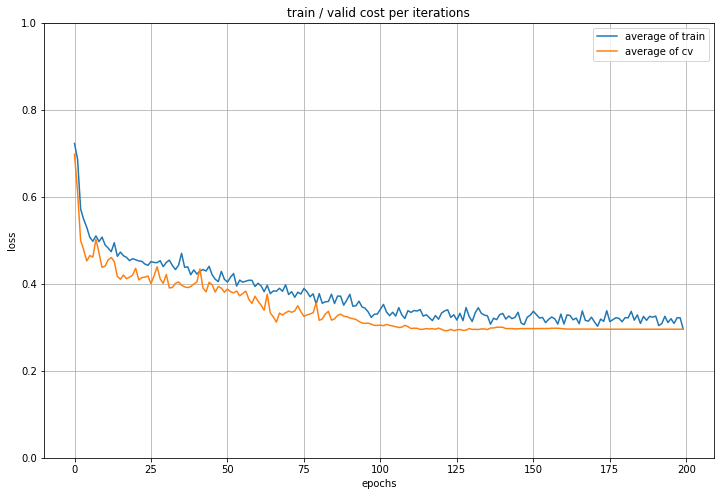

In [173]:
plt.plot(data[0]['train_cost'], label = 'average of train')
plt.plot(data[0]['valid_cost'], label = 'average of cv')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.title('train / valid cost per iterations')
axes = plt.gca()
axes.set_ylim([0, 1])
plt.grid()
plt.show()

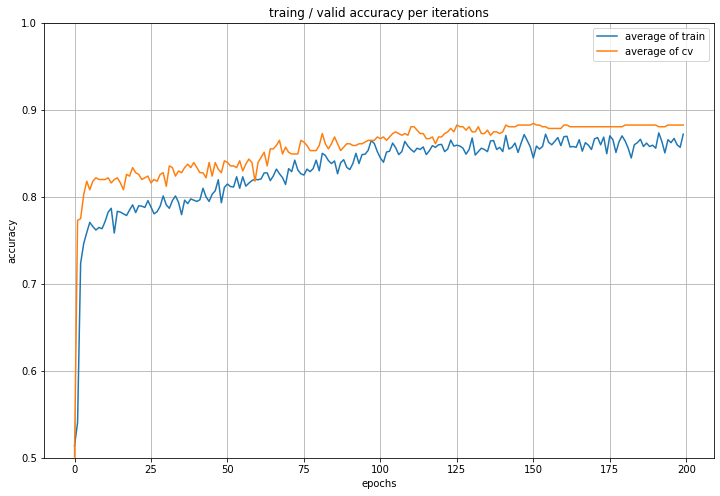

In [174]:
plt.plot(data[0]['train_acc'], label = 'average of train')
plt.plot(data[0]['valid_acc'], label = 'average of cv')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.title('traing / valid accuracy per iterations')
axes = plt.gca()
axes.set_ylim([0.5, 1])
plt.grid()
plt.show()

In [175]:
metric()

[Training average]

ACC: 0.87
LOSS: 0.3

Recall: 0.89
Specificity: 0.86
Precision: 0.86

F1: 0.87
MCC: 0.74
AUC: 0.95
----------------------------------------
[valid average]

ACC: 0.88
LOSS: 0.3

Recall: 0.89
Specificity: 0.88
Precision: 0.88

F1: 0.88
MCC: 0.77
AUC: 0.95


### Learning Curve

In [31]:
#ori
metric()

[Training average]

ACC: 0.85
LOSS: 0.35

Recall: 0.86
Specificity: 0.84
Precision: 0.84

F1: 0.85
MCC: 0.7
AUC: 0.93
----------------------------------------
[valid average]

ACC: 0.81
LOSS: 0.43

Recall: 0.9
Specificity: 0.72
Precision: 0.76

F1: 0.83
MCC: 0.63
AUC: 0.9


#### 個別

In [187]:
a1 = a2 = a3 = a4 = []
for i in range(5):
  if len(a1) == 0:
    a1 = np.array(data[0]['train_cost'].copy())
    a2 = np.array(data[0]['valid_cost'].copy())
    a3 = np.array(data[0]['train_acc'].copy())
    a4 = np.array(data[0]['valid_acc'].copy())
    continue
  a1 = a1 + np.array(data[i]['train_cost'])
  a2 = a2 + np.array(data[i]['valid_cost'])
  a3 = a3 + np.array(data[i]['train_acc'])
  a4 = a4 + np.array(data[i]['valid_acc'])

a1 /= 5 
a2 /= 5 
a3 /= 5 
a4 /= 5

a1=a1.tolist()
a2=a2.tolist()
a3=a3.tolist()
a4=a4.tolist()

training cost

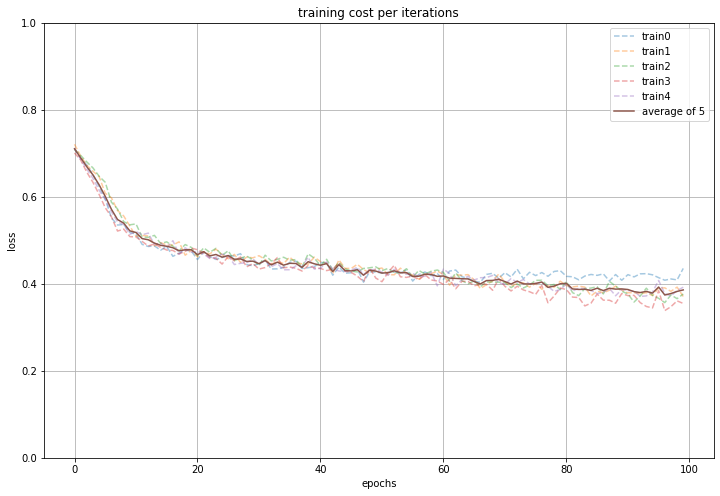

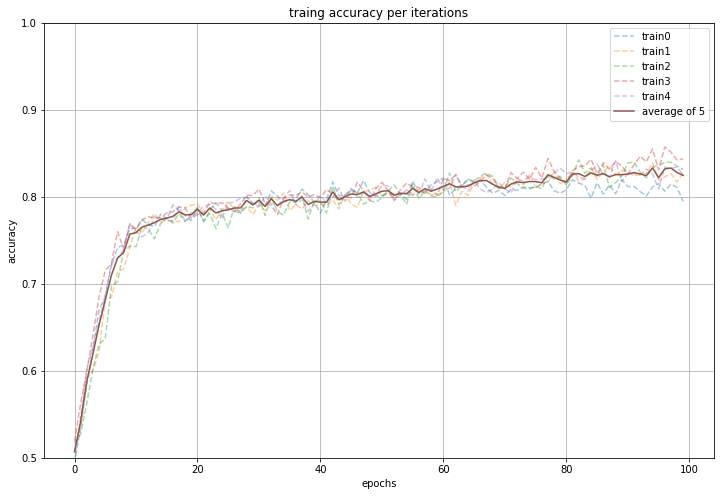

In [188]:
plt.plot(data[0]['train_cost'], '--', alpha=0.4, label = 'train0')
plt.plot(data[1]['train_cost'], '--', alpha=0.4, label = 'train1')
plt.plot(data[2]['train_cost'], '--', alpha=0.4, label = 'train2')
plt.plot(data[3]['train_cost'], '--', alpha=0.4, label = 'train3')
plt.plot(data[4]['train_cost'], '--', alpha=0.4, label = 'train4')
plt.plot(a1, label = 'average of 5')
plt.ylabel('loss')
plt.xlabel('epochs')
axes = plt.gca()
axes.set_ylim([0, 1])
plt.legend()
plt.title('training cost per iterations')
plt.grid()
plt.show()

plt.plot(data[0]['train_acc'], '--', alpha=0.4, label = 'train0')
plt.plot(data[1]['train_acc'], '--', alpha=0.4, label = 'train1')
plt.plot(data[2]['train_acc'], '--', alpha=0.4, label = 'train2')
plt.plot(data[3]['train_acc'], '--', alpha=0.4, label = 'train3')
plt.plot(data[4]['train_acc'], '--', alpha=0.4, label = 'train4')
plt.plot(a3, label = 'average of 5')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.title('traing accuracy per iterations')
axes = plt.gca()
axes.set_ylim([0.5, 1])
plt.grid()
plt.show()

valid cost

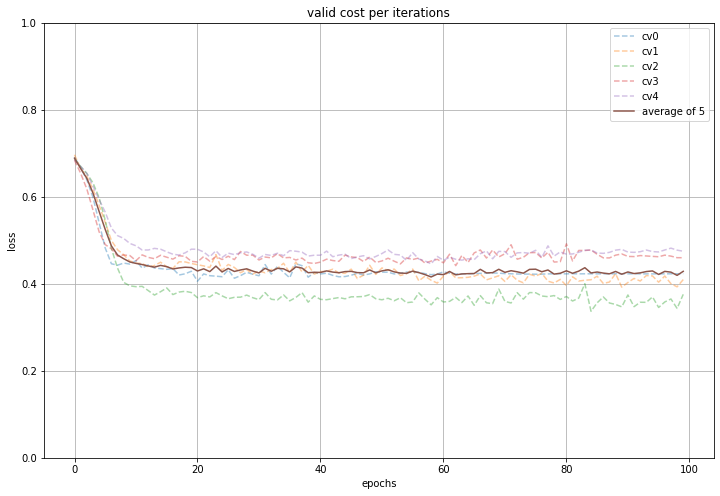

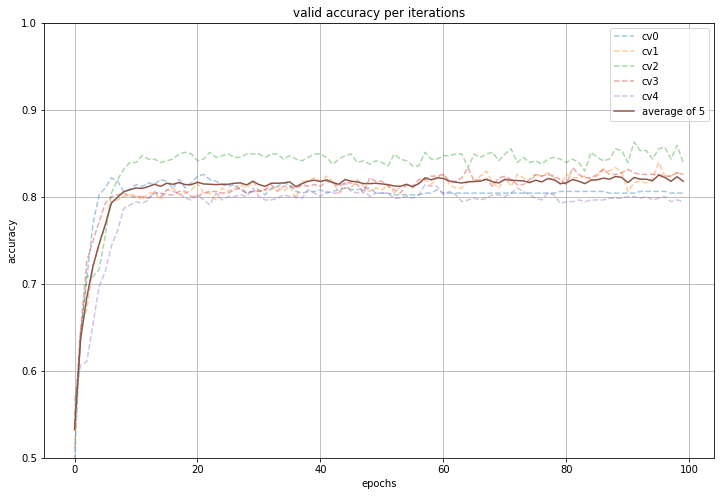

In [189]:
plt.plot(data[0]['valid_cost'], '--', alpha=0.4, label = 'cv0')
plt.plot(data[1]['valid_cost'], '--', alpha=0.4, label = 'cv1')
plt.plot(data[2]['valid_cost'], '--', alpha=0.4, label = 'cv2')
plt.plot(data[3]['valid_cost'], '--', alpha=0.4, label = 'cv3')
plt.plot(data[4]['valid_cost'], '--', alpha=0.4, label = 'cv4')
plt.plot(a2, label = 'average of 5')
plt.ylabel('loss')
plt.xlabel('epochs')
axes = plt.gca()
axes.set_ylim([0, 1])
plt.legend()
plt.title('valid cost per iterations')
plt.grid()
plt.show()

plt.plot(data[0]['valid_acc'], '--', alpha=0.4, label = 'cv0')
plt.plot(data[1]['valid_acc'], '--', alpha=0.4, label = 'cv1')
plt.plot(data[2]['valid_acc'], '--', alpha=0.4, label = 'cv2')
plt.plot(data[3]['valid_acc'], '--', alpha=0.4, label = 'cv3')
plt.plot(data[4]['valid_acc'], '--', alpha=0.4, label = 'cv4')
plt.plot(a4, label = 'average of 5')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.title('valid accuracy per iterations')
axes = plt.gca()
axes.set_ylim([0.5, 1])
plt.grid()
plt.show()

#### 平均

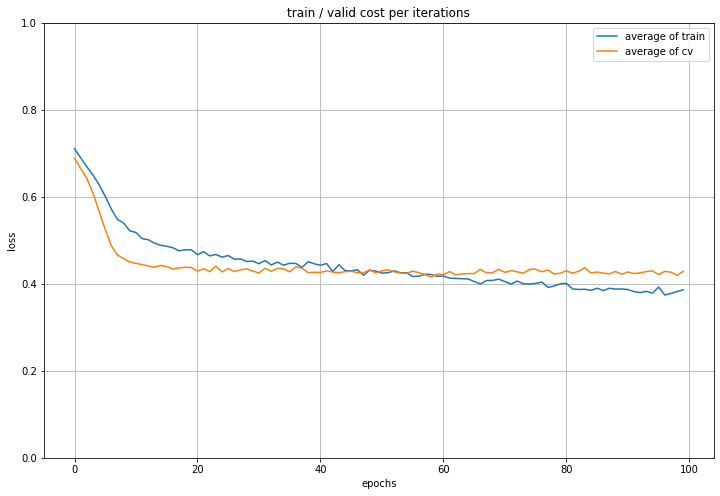

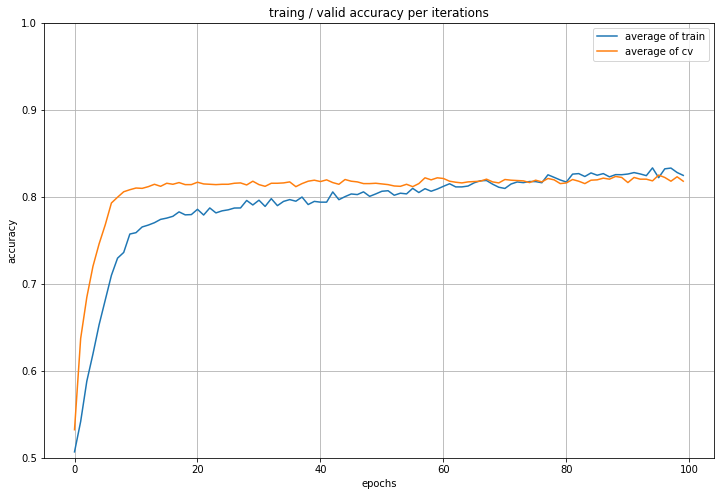

In [190]:
plt.plot(a1, label = 'average of train')
plt.plot(a2, label = 'average of cv')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.title('train / valid cost per iterations')
axes = plt.gca()
axes.set_ylim([0, 1])
plt.grid()
plt.show()

plt.plot(a3, label = 'average of train')
plt.plot(a4, label = 'average of cv')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.title('traing / valid accuracy per iterations')
axes = plt.gca()
axes.set_ylim([0.5, 1])
plt.grid()
plt.show()

In [191]:
metric()

[Training average]

ACC: 0.82
LOSS: 0.39

Recall: 0.84
Specificity: 0.81
Precision: 0.82

F1: 0.83
MCC: 0.65
AUC: 0.91
----------------------------------------
[valid average]

ACC: 0.82
LOSS: 0.43

Recall: 0.91
Specificity: 0.72
Precision: 0.77

F1: 0.83
MCC: 0.65
AUC: 0.91


### tensorboard

In [18]:
from torchsummary import summary
#device = torch.device('cuda:0')
summary(model.to(device), (4,34))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 24, 34]             504
               ELU-2               [-1, 24, 34]               0
MultiheadAttention-3  [[-1, 24, 34], [-1, 2, 2]]               0
           Dropout-4               [-1, 24, 34]               0
         LayerNorm-5               [-1, 24, 34]              68
            Linear-6             [-1, 24, 2048]          71,680
           Dropout-7             [-1, 24, 2048]               0
            Linear-8               [-1, 24, 34]          69,666
           Dropout-9               [-1, 24, 34]               0
        LayerNorm-10               [-1, 24, 34]              68
TransformerEncoderLayer-11               [-1, 24, 34]               0
        GroupNorm-12               [-1, 24, 34]              48
        MaxPool1d-13                [-1, 24, 8]               0
          Flatten-14            